In [1]:
import torch
from torch.utils.data import DataLoader
import argparse
from models import caption
from datasets import refcoco
from configuration import Config
import os
import json
import matplotlib.pyplot as plt

from eval_utils.decode import prepare_tokenizer, greedy_with_att
from engine import pack_encoder_inputs

from skimage import io
from PIL import Image
from os.path import join
from datasets.utils import pad_img_to_max, crop_image_to_bb
import numpy as np
import cv2
from skimage.filters import gaussian

from results.utils import display_target_distractors, parse_filename
from datasets.utils import get_refcoco_df, filename_from_id

def prepare_model(checkpoint_pth, config):

    if not os.path.exists(checkpoint_pth):
        raise NotImplementedError("Give valid checkpoint path")
    else:
        model, _ = caption.build_model(config)
        checkpoint = torch.load(checkpoint_pth, map_location="cpu")
        model.load_state_dict(checkpoint["model_state_dict"])

    return model


def setup_val_dataloader(config):
    dataset_val = refcoco.build_dataset(
        config, 
        mode="validation", 
        return_unique=True)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    data_loader_val = DataLoader(
        dataset_val,
        batch_size=config.batch_size,
        sampler=sampler_val,
        drop_last=False,
        num_workers=config.num_workers,
    )
    return dataset_val, data_loader_val

/home/simeon/.anaconda3/envs/context_representations/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def avg_att_layer(att_values):

    # average over layer
    mean_att_values = att_values.mean(0)  # [batch, q_dim, kv_dim]
    
    # only works for bs=1
    assert mean_att_values.shape[0] == 1
    mean_att_values = mean_att_values[0]
    
    return mean_att_values

def reshape_2d_att(att, wh_dim=14):
    assert att.shape[-1] == wh_dim**2
    # average over all features
    att = att.mean(0)
    return att.view(wh_dim, wh_dim)
    

def plot_att(att):
    
    plt.matshow(
        att
    )
    
def interpolate_2d(tensor, shape):
    return torch.nn.functional.interpolate(tensor.unsqueeze(0).unsqueeze(0), shape).squeeze(0).squeeze(0)

def normalize_to_255(image):
    return image * (255 / image.max())

def make_heatmap(entry, att, mode='context', config=config, w=0.5, sigma=15, display_result=True):
    # Retrieve & display the image
    image_file = filename_from_id(entry.image_id, prefix='COCO_train2014_')
    image_filepath = join(config.dir, 'train2014', image_file)
    
    img = cv2.imread(image_filepath)
    
    if mode == 'context':
        pass
    elif mode == 'target':
        img = Image.fromarray(img)
        img, _ = crop_image_to_bb(img, entry.bbox, return_context=False)
        img = np.array(img)
    else: 
        raise NotImplementedError("mode has to be 'target' or 'context'")
        
    padded_img = np.array(pad_img_to_max(Image.fromarray(img)))
        
    image_shape = padded_img.shape[:2]
    att = interpolate_2d(att, image_shape).numpy()
    att = gaussian(att, sigma=sigma)
    
    normalized_att = normalize_to_255(att).astype('uint8')
    heatmap_img = cv2.applyColorMap(normalized_att, cv2.COLORMAP_JET)
    
    super_imposed_img = cv2.addWeighted(heatmap_img, w, padded_img, 1-w, 0)
    super_imposed_img = cv2.cvtColor(super_imposed_img, cv2.COLOR_BGR2RGB)
    
    if display_result:
        display(Image.fromarray(super_imposed_img))
    
    else:
        return super_imposed_img

In [2]:
args = argparse.Namespace(
    checkpoint='data/models/refcoco/DecoderCrossAtt_refcoco_loc_glob_checkpoint_10.pth'
)

config = Config()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# prepare refcoco df

refcoco_df = get_refcoco_df(config.ref_dir)

refcoco_df = refcoco_df.reset_index().groupby('ann_id').agg({
    'sent_id': list, 'caption': list, 
    'ref_id': 'first', 'refcoco_split': 'first', 
    'coco_split': 'first', 'image_id': 'first', 
    'bbox': 'first'
}).reset_index()

refcoco_df.index = refcoco_df.ann_id.values

# prepare model / tokenizer / dataloader

model = prepare_model(args.checkpoint, config)
tokenizer, _, _ = prepare_tokenizer()
val_set, val_loader = setup_val_dataloader(config)

pad_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
bos_id = tokenizer.convert_tokens_to_ids(tokenizer.cls_token)
eos_id = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)

Using sine/cosine positional encodings
global features: True, location features: True, scene summaries: False
Built CaptionGlobalLoc model with DecoderCrossAttTransformer
Initialize Dataset with mode: validation 
target transformation: {'resize': Resize(size=[224], interpolation=bilinear, max_size=None, antialias=None), 'transform': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)} 
context transformation: {'resize': Resize(size=[224], interpolation=bilinear, max_size=None, antialias=None), 'transform': Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)} 
entries: 10834 
return unique: True 



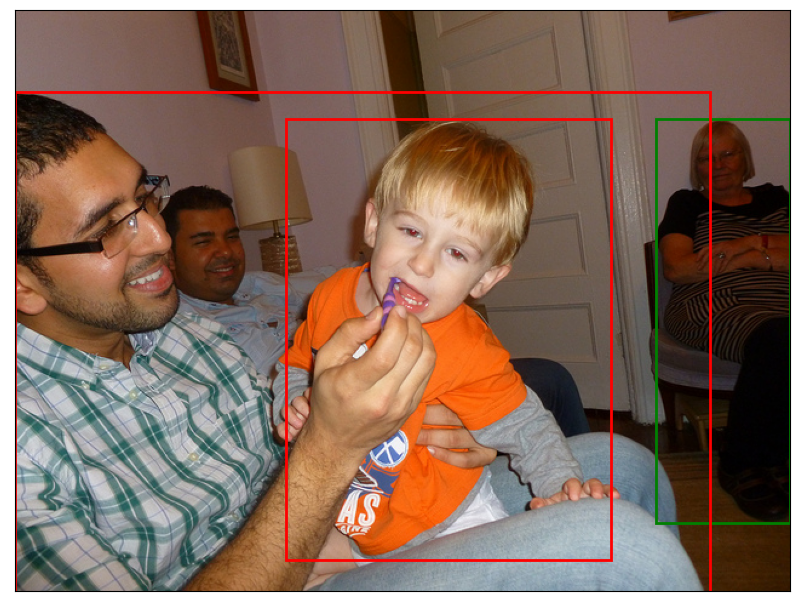

annotated: right
generated: woman on right


In [167]:
idx = 190
ann_id = val_set.annot_select[idx][0]

# get refcoco entry
entry = refcoco_df.loc[ann_id]

# Retrieve & display the image
image_file = filename_from_id(entry.image_id, prefix='COCO_train2014_')
image_filepath = join(config.dir, 'train2014', image_file)
image = io.imread(image_filepath)

# pad to square
image = pad_img_to_max(Image.fromarray(image))

# prepare model inputs

ann_id, *encoder_input, cap, cap_mask = val_set[idx]

encoder_input = [e.unsqueeze(0) for e in encoder_input]
cap = torch.from_numpy(cap).unsqueeze(0)
cap_mask = torch.from_numpy(cap_mask).unsqueeze(0)

sample = pack_encoder_inputs(
    encoder_input, 
    val_set.return_global_context,
    val_set.return_location_features,
    val_set.return_scene_features,
    device)

# show item

annot = val_set.annot_select[idx]

display_target_distractors(entry_id=ann_id, refcoco_data=refcoco_df, coco_base=config.dir)

print('annotated:', annot[2])

# generate with model

generated, atts = greedy_with_att(model, sample, tokenizer, start_token=bos_id, end_token=eos_id, return_raw=True)

print('generated:', tokenizer.decode(generated, skip_special_tokens=True))

In [168]:
print(atts[0].keys())

dict_keys(['enc_t_self_att', 'enc_c_self_att', 'dec_exp_self_att', 'dec_exp_t_cross_att', 'dec_exp_c_cross_att'])


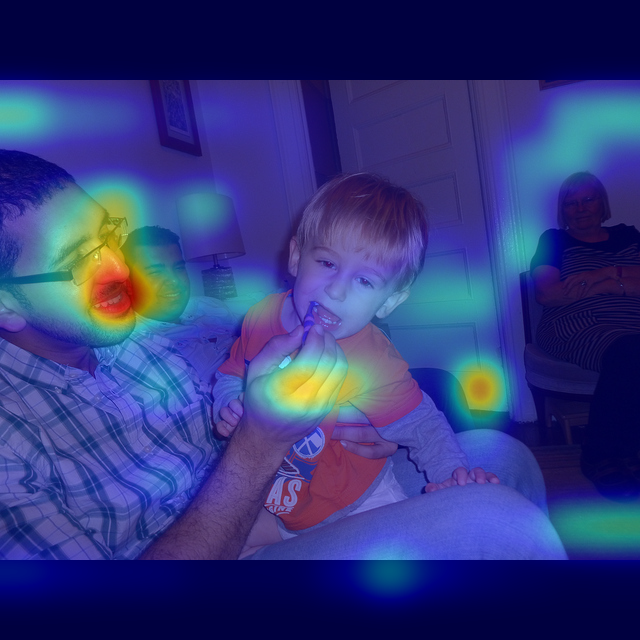

[ C L S ] 




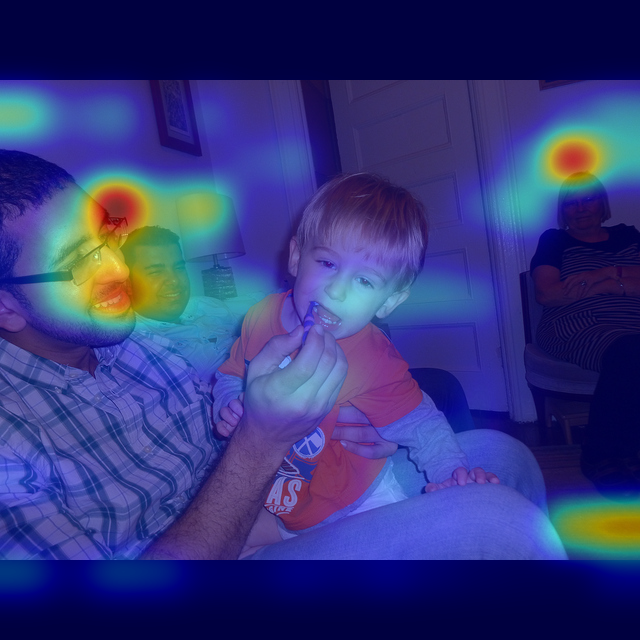

w o m a n 




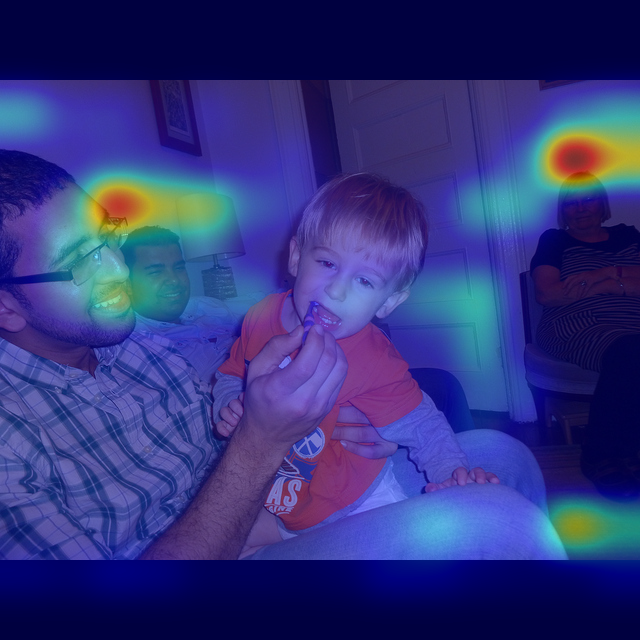

o n 




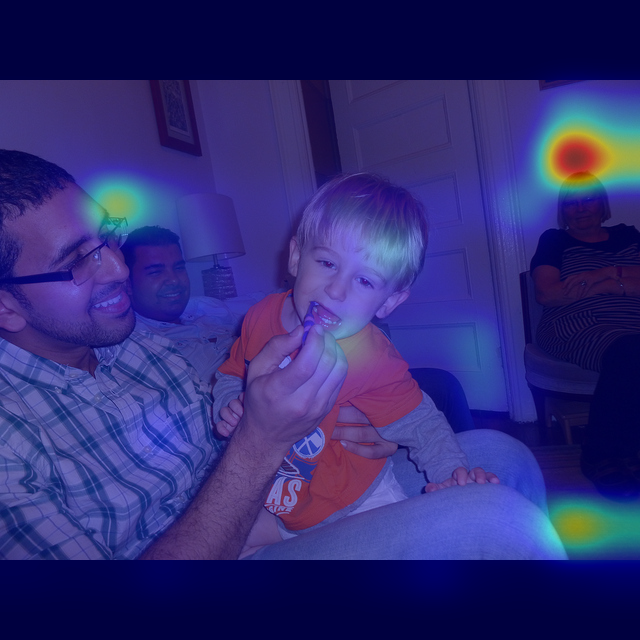

r i g h t 




In [169]:
att_layer_name = 'dec_exp_c_cross_att'

for token, att_dict in zip(generated, atts):
    token = tokenizer.decode(token)
    
    att = att_dict[att_layer_name]
    att = avg_att_layer(att)  # kv_dim
    att = reshape_2d_att(att)
    make_heatmap(entry, att, mode='context')
    
    print(token, '\n\n')

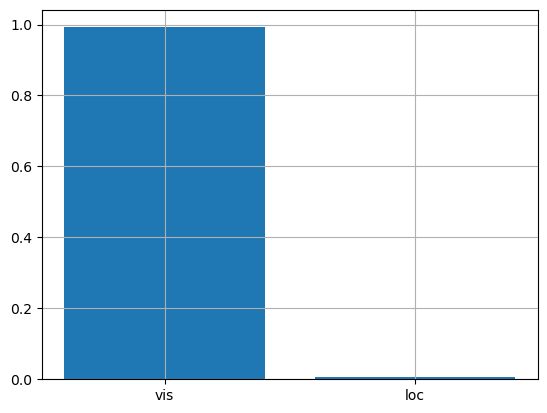

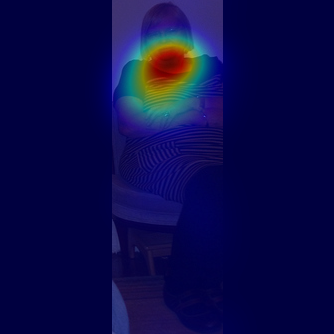

[ C L S ] 




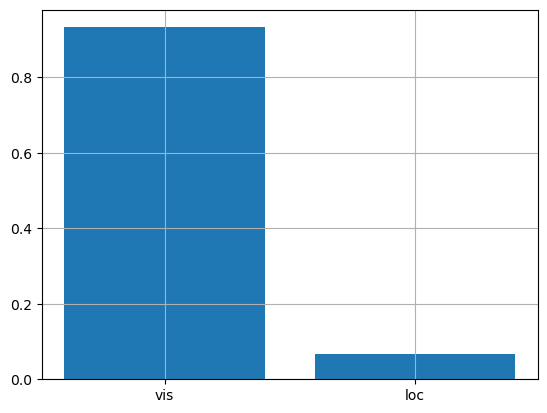

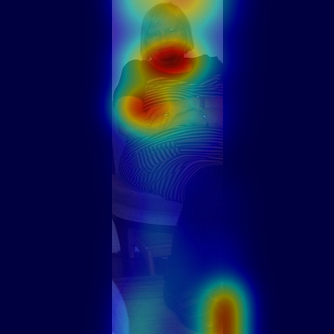

w o m a n 




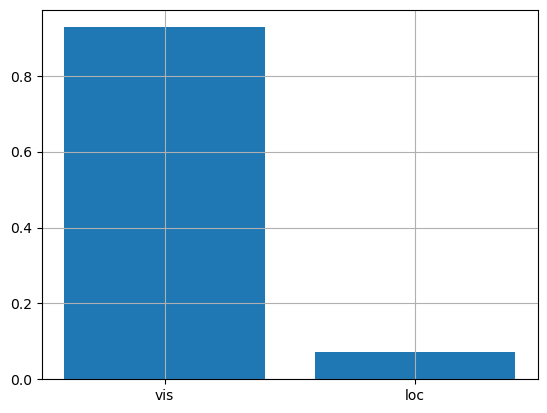

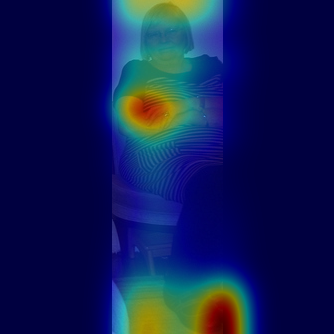

o n 




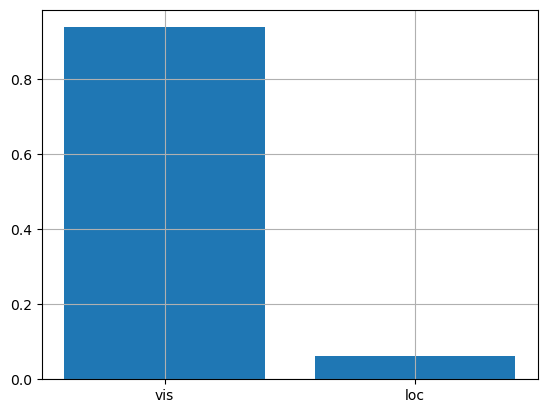

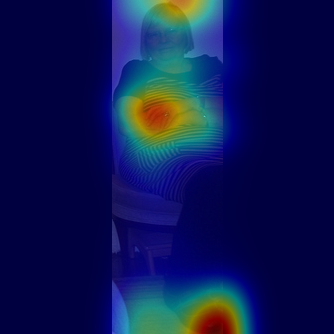

r i g h t 




In [170]:
att_layer_name = 'dec_exp_t_cross_att'

for token, att_dict in zip(generated, atts):
    token = tokenizer.decode(token)
    
    att = att_dict[att_layer_name]
    att = avg_att_layer(att)  # kv_dim
    
    vis_att = att[:, :-1]
    loc_att = att[:, -1]
    total_vis = vis_att.sum()
    total_loc = loc_att.sum()
    vis = total_vis / (total_vis + total_loc)
    loc = total_loc / (total_vis + total_loc)
    plt.bar(['vis', 'loc'],[vis, loc])
    plt.grid()
    plt.show()
    
    vis_att = reshape_2d_att(vis_att)
    make_heatmap(entry, vis_att, mode='target')
    
    print(token, '\n\n')

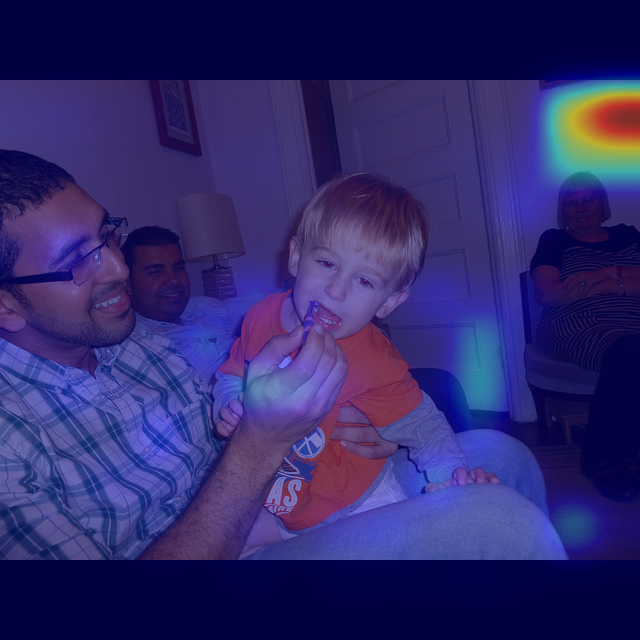

[ C L S ] 




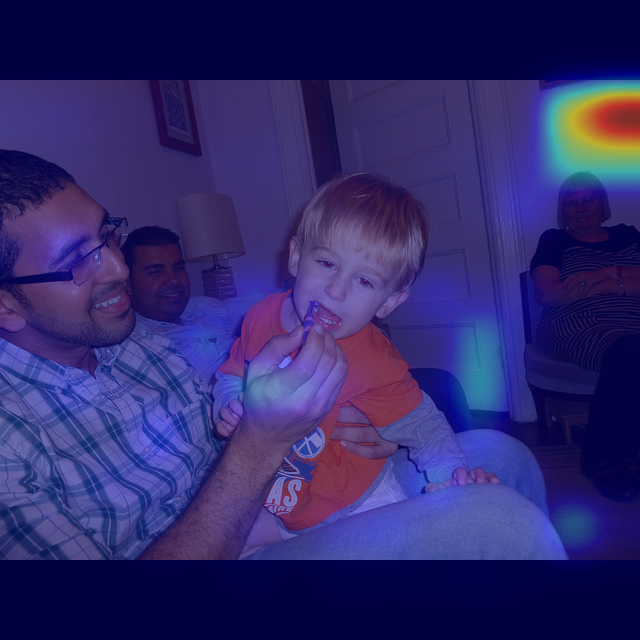

w o m a n 




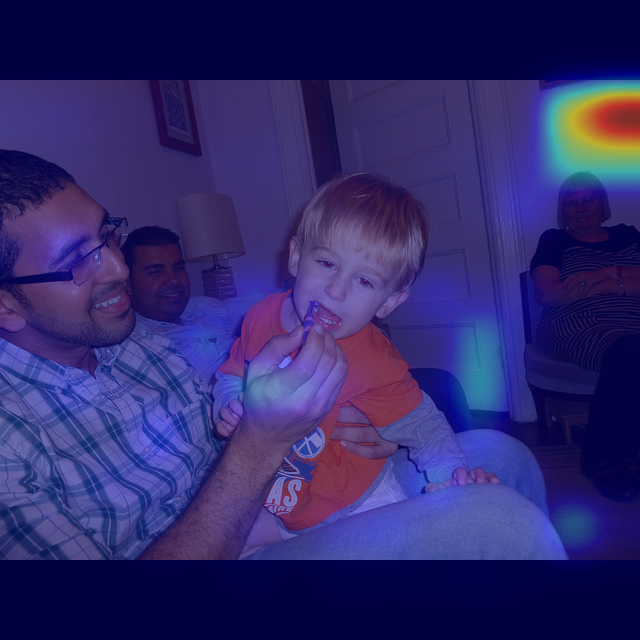

o n 




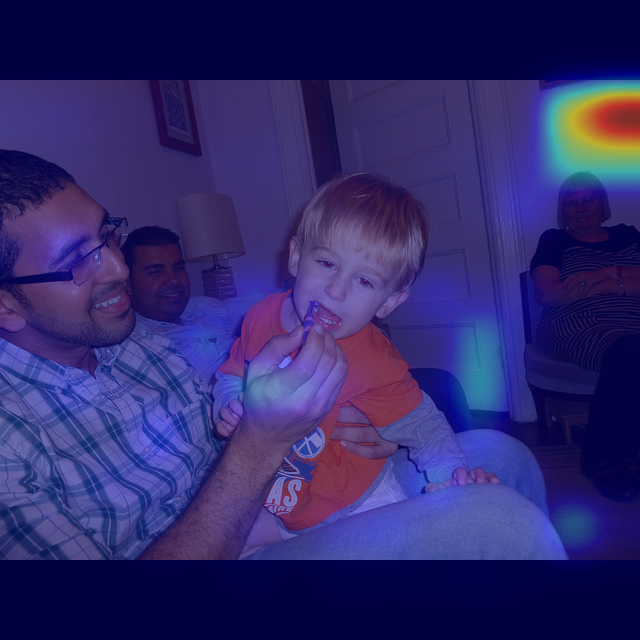

r i g h t 




In [171]:
att_layer_name = 'enc_c_self_att'

for token, att_dict in zip(generated, atts):
    token = tokenizer.decode(token)
    
    att = att_dict[att_layer_name]
    att = avg_att_layer(att)  # kv_dim
    att = reshape_2d_att(att)
    make_heatmap(entry, att, mode='context')
    
    print(token, '\n\n')

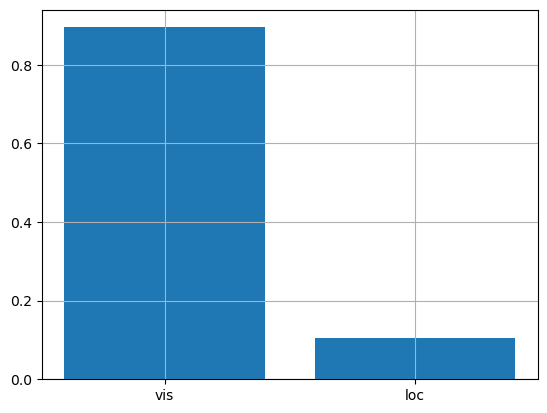

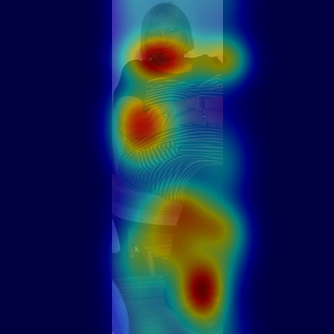

[ C L S ] 




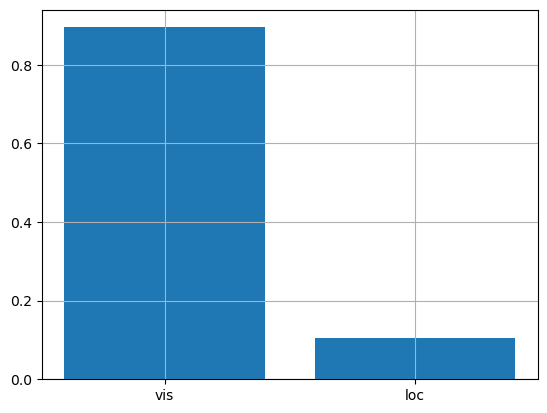

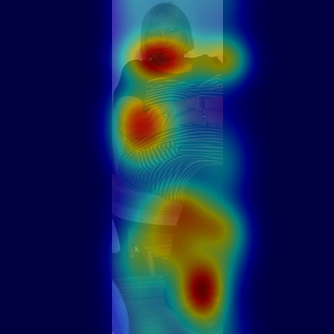

w o m a n 




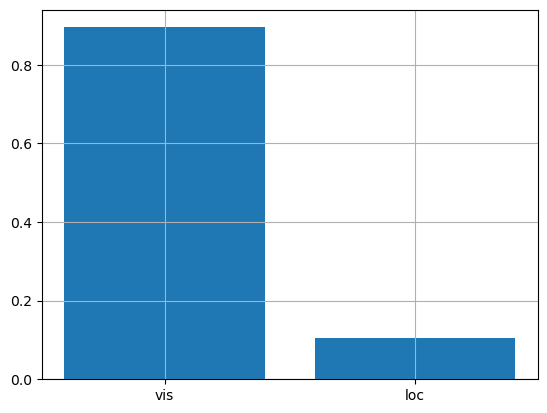

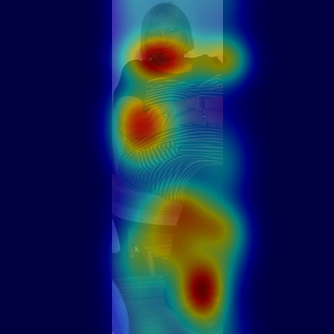

o n 




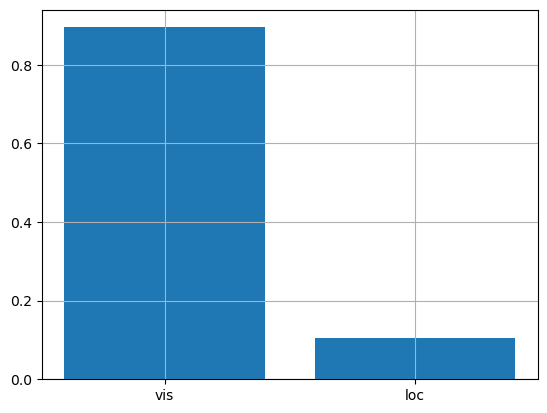

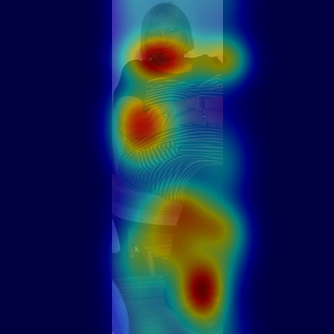

r i g h t 




In [172]:
att_layer_name = 'enc_t_self_att'

for token, att_dict in zip(generated, atts):
    token = tokenizer.decode(token)
    
    att = att_dict[att_layer_name]
    att = avg_att_layer(att)  # kv_dim
    
    vis_att = att[:, :-1]
    loc_att = att[:, -1]
    total_vis = vis_att.sum()
    total_loc = loc_att.sum()
    vis = total_vis / (total_vis + total_loc)
    loc = total_loc / (total_vis + total_loc)
    plt.bar(['vis', 'loc'],[vis, loc])
    plt.grid()
    plt.show()
    
    vis_att = reshape_2d_att(vis_att)
    make_heatmap(entry, vis_att, mode='target')
    
    print(token, '\n\n')